In [1]:
# imports
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)

In [1]:
# CORE DATA COLLECTION AND PROCESSING

import pandas as pd
import numpy as np
#import datetime

# VARIABLES
# Countries of interest
countries = ['Italy','Spain','UK','Germany','US','France','Sweden']

# Population to adjust all numbers to
rebase_population = 50E6

# Starting date for charts etc.
start_date = pd.Timestamp(2020,3,1)

# Excel output file
excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output.xlsx'

# Covid-19 CSV data source
cv19_csv_source = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#Population CSV data source
pop_csv_source = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\population-2019.csv'

# LOAD & PROCESS COVID-19
cdf = pd.read_csv(cv19_csv_source)

# Rename CV19 columns with illegal characters to something safe
cdf.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)
# Rename long country names
cdf = cdf.replace({'United Kingdom':'UK'})

# keep only the State=NaN rows to make Country unique
cdf = cdf[cdf['State'].isin([np.nan])]

# Drop unnecesary columns
cdf = cdf.drop(['State','Lat','Long'], axis='columns')

# Filter to countries of interest
cdf = cdf[cdf['Country'].isin(countries)]

# Transpose to time series
cdf = cdf.T

# Make top row the Column index
cdf.columns = cdf.iloc[0]
cdf = cdf.drop(cdf.index[0])

# Rename column axis
cdf = cdf.rename_axis(index='Country')

# Rename row axis
cdf = cdf.rename_axis(index='Date', axis=1)

# Convert index strings into dates
cdf = cdf.set_index(pd.to_datetime(cdf.index, format='%m/%d/%y'))

# Drop all rows before start date
cdf = cdf[cdf.index >= start_date]

print('Covid-19 data imported & normalized from {}'.format(cv19_csv_source))

# LOAD & PROCESS POPULATION DATA
pdf = pd.read_csv(pop_csv_source)

# Rename country names in population to allow later join
pdf = pdf.replace({'United States of America':'US', 'United Kingdom':'UK'})

# Rename columns for consistency with CV19 data
pdf = pdf.rename(columns={'Location':'Country'})

# Only keep relevant columns
pdf = pdf[['Country','PopMale','PopFemale','PopTotal','PopDensity']]

# Filter to countries of interest
pdf = pdf[pdf['Country'].isin(countries)]

# Make first column the row index
pdf.index = pdf['Country']
pdf = pdf.drop('Country', axis='columns')

# Rename axes
pdf = pdf.rename_axis(index='Datum', axis='index')
pdf = pdf.rename_axis(index='Country', axis='columns')

# Convert populations to correct numbers (source is in 1000's)
pdf[['PopMale','PopFemale','PopTotal']] = pdf[['PopMale','PopFemale','PopTotal']].mul(1000)

# Calculate population multiplier column (factor to normalise into standard population)
pdf[['PopMultiplier']] = 1/(pdf[['PopTotal']]/rebase_population)

print('Population data imported & normalized from {}'.format(pop_csv_source))

# DATA CHECKS

# Check 1:1 mapping between data sets (note different axes)
assert cdf.columns.size == pdf.index.size, 'Data-sets have different country sets - maybe country name mismatch?'
print('Data checks pass')

# CALCULATE
# Generate the output data frames for all charts

# Absolute and pop adjusted total deaths
cdf_abssum = cdf
cdf_adjsum = cdf_abssum.multiply(pdf['PopMultiplier'])

# Absolute and pop adjusted daily adjusted deaths
cdf_absdaily = cdf_abssum.diff()
cdf_adjdaily = cdf_absdaily.multiply(pdf['PopMultiplier'])

print('Calculated dataframes ready')

# EXPORT
# Dump to a single Excel sheet with multiple worksheets

with pd.ExcelWriter(excel_output_file, date_format='YYYY-MM-DD') as xl:
        cdf_abssum.to_excel(xl, sheet_name='Abs Sum Deaths')
        cdf_adjsum.to_excel(xl, sheet_name='Adj Sum Deaths')
        cdf_absdaily.to_excel(xl, sheet_name='Abs Daily Deaths')
        cdf_adjdaily.to_excel(xl, sheet_name='Adj Daily Deaths')

print('Excel output file written : {}'.format(excel_output_file))

Covid-19 data imported & normalized from https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
Population data imported & normalized from C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\population-2019.csv
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output.xlsx


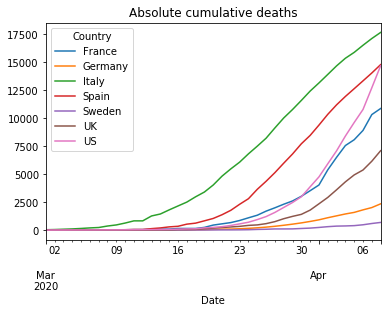

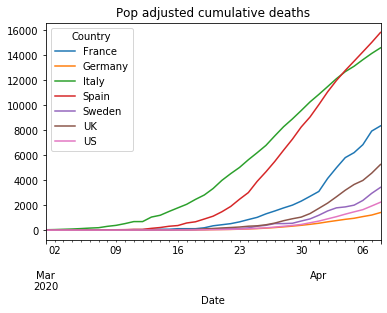

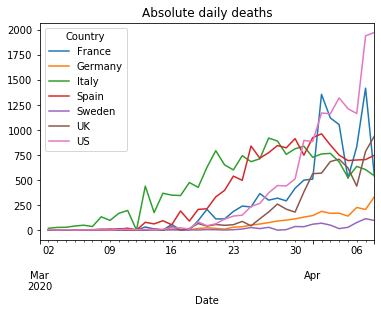

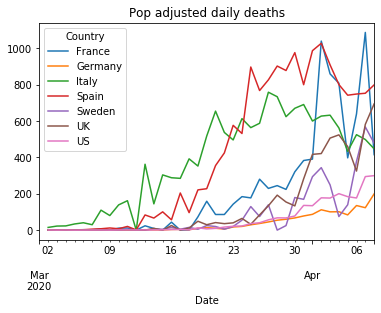

In [16]:
# PLOT THE CHARTS

import matplotlib.pyplot as plt
import os

plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'

# plots to produce key is dataframe variable name, value is (filename, title)
export_plots = {
    'cdf_abssum':('cumulative-deaths.png','Absolute cumulative deaths'),
    'cdf_adjsum':('pop-adjusted-cumulative-deaths.png','Pop adjusted cumulative deaths'),
    'cdf_absdaily':('absolute-daily-deaths.png','Absolute daily deaths'),
    'cdf_adjdaily':('pop-adjusted-daily-deaths.png','Pop adjusted daily deaths')}

# print plot and dump to file for each of the above
for k, (filename, title) in export_plots.items():
    d = locals()[k]
    filepath = os.path.join(plot_export_folder, filename)
    d.plot(title=title)
    plt.savefig(filepath)

In [17]:
# COPY DATA TO PUBLIC FOLDER
import shutil

public_folder = r'C:\Users\Jon Sturley\OneDrive\Public\covid-19'

# Copy Excel output data to public folder
try:
    shutil.copy(excel_output_file, public_folder)
except PermissionError as e:
    print('Permission denied - data file may be open in Excel')

# Copy charts to public folder
for k, (filename, title) in export_plots.items():
    filepath = os.path.join(plot_export_folder, filename)
    shutil.copy(filepath, public_folder)

Todo:
    - Improve chart quality
    - Set up static web site on AWS S3
    - Add function to upload to S3 bucket
    - Schedule job to run Python every day on AWS